In [1]:
import torch 
import torch.nn as nn
import lightning as L 
from torchmetrics import Accuracy
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
import timm

import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import confusion_matrix

from data.MRIDataModule_Alexandre import MRIDataModule

In [7]:
class MyModel(L.LightningModule):
    def __init__(self, 
                 lr: float = 0.001, 
                 weight_decay: float = 1e-4, 
                 num_class: int = 1, 
                 *args, 
                 **kwargs):
        
        super().__init__()
        self.save_hyperparameters()

        ## Modèle pré-entraîné : ResNet50 et de la librairie timm
        self.model = timm.create_model(
            'resnet51q.ra2_in1k',
            pretrained=True,
            pretrained_cfg_overlay=dict(file='../Timm/resnet50.safetensors'),
            in_chans=1,
            num_classes=self.hparams.num_class,
        )
        
        ## Modification de la dernière couche pour une classification binaire
        in_features = self.model.get_classifier().in_features
        self.model.fc = nn.Linear(in_features, 1)
        
        ## Loss : BinaryCrossEntropy pour une classification binaire
        self.loss_train = nn.BCEWithLogitsLoss()
        self.loss_val = nn.BCEWithLogitsLoss()
        self.loss_test = nn.BCEWithLogitsLoss()
        
        ## Accuracy pour la classification binaire
        self.train_acc = Accuracy(task="binary")
        self.valid_acc = Accuracy(task="binary")
        self.test_acc = Accuracy(task="binary")
        
        self.train_labels = []
        self.train_preds = []
 
    def forward(self, x):
        logits = self.model(x)
        return logits
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device).float()  # Convertir les étiquettes en float pour BCEWithLogitsLoss
        y_hat = self(x)
        loss = self.loss_train(y_hat.squeeze(), y)
        preds = torch.sigmoid(y_hat.squeeze()) >= 0.5  # Appliquer sigmoid et seuil
        acc = self.train_acc(preds, y.int())
        self.log('train/loss', loss, prog_bar=True, on_step=True, on_epoch=True, sync_dist=True)
        self.log('train/acc', acc, prog_bar=True, on_step=True, on_epoch=True, sync_dist=True)
 
        self.train_labels.append(y.cpu())
        self.train_preds.append(preds.cpu())
        return loss
    
    def on_epoch_end(self):
        all_labels = torch.cat(self.train_labels)
        all_preds = torch.cat(self.train_preds)
        cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
        self.log_confusion_matrix(cm)
        self.train_labels = []
        self.train_preds = []
 
    def log_confusion_matrix(self, cm):
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=[0, 1],
                    yticklabels=[0, 1])
        ax.set_xlabel('Labels prédits')
        ax.set_ylabel('Labels vrais')
        ax.set_title('Matrice de Confusion pour le Meilleur Modèle')
        plt.savefig('best_model_confusion_matrix.png')
        plt.close()
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device).float()
        preds = self(x)
        loss = self.loss_val(preds.squeeze(), y)
        preds = torch.sigmoid(preds.squeeze()) >= 0.5
        acc = self.valid_acc(preds, y.int())
        self.log('val/loss', loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        self.log('val/acc', acc, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        return {'val_loss': loss}

    def test_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device).float()
        preds = self(x)
        loss = self.loss_test(preds.squeeze(), y)
        preds = torch.sigmoid(preds.squeeze()) >= 0.5
        acc = self.test_acc(preds, y.int())
        self.log('test/loss', loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        self.log('test/acc', acc, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        return {'test_loss': loss}
 
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)

In [8]:
checkpoint_callback = ModelCheckpoint(
    monitor="val/loss",
    dirpath="checkpoints3/",
    filename="best_model",
    save_top_k=1,
    mode="min",
)
early_stopping_callbak = EarlyStopping(
    monitor="val/loss",
    mode="min",
    patience=50,
    verbose=True
)
trainer = L.Trainer(
    callbacks=[checkpoint_callback, early_stopping_callbak],
    max_epochs=500,
    accelerator='gpu',
    devices=1
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [9]:
model = MyModel()

In [10]:
db_path = '../data'
task = 'classification'
manifest = f'MRI_dataset_{task}.csv'

data = MRIDataModule(
    dataset_path=db_path,
    manifest_filename=manifest,
    batch_size=4,
    task=task,
    crop_size=None,
    train_val_test_shuffle=(True, False, False),
    train_val_test_split=(0.8,0.1,0.1),
    #train_val_test_split=(1,0,0),
    seed=23,
    verbose=True,
    normalization='max',
    num_workers=None,
)

data.prepare_data()
data.setup('train')


trainset size: 800
validation size: 95
testset size: 105


In [11]:
trainer.fit(model, data)

C:\Users\M105411\AppData\Roaming\Python\Python310\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:652: Checkpoint directory C:\Users\M105411\Documents\IA_Med_Im\IA_Med_Im_PyTorch\checkpoints3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | model      | ByobNet           | 33.7 M | train
1 | loss_train | BCEWithLogitsLoss | 0      | train
2 | loss_val   | BCEWithLogitsLoss | 0      | train
3 | loss_test  | BCEWithLogitsLoss | 0      | train
4 | train_acc  | BinaryAccuracy    | 0      | train
5 | valid_acc  | BinaryAccuracy    | 0      | train
6 | test_acc   | BinaryAccuracy    | 0      | train
---------------------------------------------------------
33.7 M    Trainable params
0         Non-trainable params
33.7 M    Total params
134.607   Total estimated model params size (MB)


trainset size: 830
validation size: 110
testset size: 60


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\M105411\AppData\Roaming\Python\Python310\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


RuntimeError: Detected the following values in `target`: tensor([3], device='cuda:0', dtype=torch.int32) but expected only the following values [0, 1].

In [ ]:
best_model_path = checkpoint_callback.best_model_path
#best_model_path = "C:/Users/M105411/Documents/IA_Med_Im/IA_Med_Im_PyTorch/checkpoints3/best_model-v14.ckpt"
print(best_model_path)
best_model = MyModel.load_from_checkpoint(best_model_path)
best_model.eval()

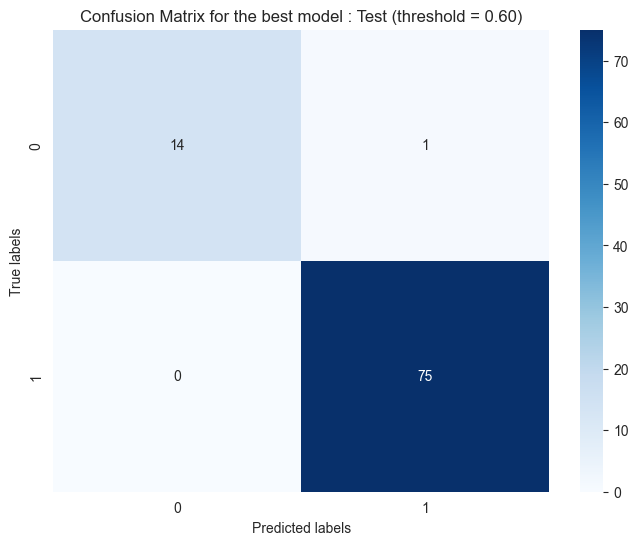

In [68]:
val_data = data.test_dataloader()  # Modifiez cela pour correspondre à votre DataLoader
 
val_labels = []
val_preds  = []
val_probs  = []  # Pour stocker les probabilités
 
with torch.no_grad():
    for batch in val_data:
        x, y = batch
        x, y = x.to(best_model.device), y.to(best_model.device)
        preds = best_model(x)
        val_labels.append(y.cpu())
        val_preds.append((torch.sigmoid(preds).squeeze() >= 0.60).cpu())
        val_probs.append(torch.sigmoid(preds).cpu())  # Ajouter les probabilités

val_labels = torch.cat(val_labels)
val_preds  = torch.cat(val_preds)
val_probs  = torch.cat(val_probs)  # Concaténer les probabilités
 
# Calculer et afficher la matrice de confusion
cm = confusion_matrix(val_labels, val_preds, labels=[0, 1])
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=[0, 1],
            yticklabels=[0, 1])
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for the best model : Test (threshold = 0.60)')
plt.savefig('best_model_confusion_matrix_test.png')
plt.show()